In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/Colab Notebooks/Udacity/Machine Learning ND/Capstone Project

/content/drive/My Drive/Colab Notebooks/Udacity/Machine Learning ND/Capstone Project


# Prediction Stock Price (DAX) by using Machine Learning Techniques (LSTM and Linear Regression)

Florian Harsch
4th December 2019

## 1. Set up infrastructure

In [3]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
# import necessary libraries 
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import tensorflow as tf

keras = tf.keras

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

## 2. Data Preprocessing

**Read Data**

In [0]:
# I downloaded the the development of DAX starting 15/05/2002 to 18/09/2019 from Yahoo finance and stored it as csv
# read csv file to dataframe
df_dax = pd.read_csv('DAX_20021505_20190918.csv')
# Also downloaded the development of VDAX for the same time frame from ariva and stored it as csv
# read csv file to dataframe
df_vdax = pd.read_csv('VDAX_20021505_20190918.csv', sep=';', header = 0, decimal = ',')

**Rename Columns**

As the column names of both dataframes are mixed in German and English. To clearly identify the source in a merged dataframe, I rename the colums and then I will merge both dataframes to one new.

In [0]:
# rename columns names pf DAX
df_dax.columns = ["Date",'DAX_open', 'DAX_high', 'DAX_low', 'DAX_close', 'DAX_adj_close', 'DAX_volume']

# rename columns names pf DAX
df_vdax.columns = ["Date",'VDAX_open', 'VDAX_high', 'VDAX_low', 'VDAX_close', 'VDAX_pieces', 'VDAX_volume']

**Merge both dataframes**

I will merge both dataframes by their date column date.

In [0]:
df = pd.merge(df_dax, df_vdax, on="Date")

**Examine dataframe**

In [0]:
df.describe()

,DAX_open,DAX_high,DAX_low,DAX_close,DAX_adj_close,DAX_volume,VDAX_open,VDAX_high,VDAX_low,VDAX_close,VDAX_pieces,VDAX_volume
count,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4.384000e+03,4385.000000,4385.000000,4385.000000,4385.000000,46.0,47.000000
mean,7525.720076,7578.205504,7467.978684,7525.047971,7525.047971,1.141532e+08,22.999629,23.579162,22.394042,22.920706,0.0,-0.021277
std,2948.154186,2956.229518,2939.166379,2947.445914,2947.445914,4.848173e+07,9.838002,10.043545,9.693623,9.869913,0.0,0.145865
min,2203.969971,2319.649902,2188.750000,2202.959961,2202.959961,0.000000e+00,11.082900,11.346300,10.482900,10.978400,0.0,-1.000000
25%,5245.510010,5303.679810,5174.027344,5247.004883,5247.004883,8.443432e+07,16.482000,16.928000,15.974000,16.364000,0.0,0.000000
50%,6958.265137,6996.889893,6905.434814,6954.179931,6954.179931,1.032070e+08,20.071500,20.600000,19.527000,20.007700,0.0,0.000000
75%,9943.045166,10016.855225,9891.199951,9949.887207,9949.887207,1.312990e+08,25.806000,26.393000,25.108700,25.767000,0.0,0.000000
max,13577.139648,13596.889648,13517.809570,13559.599609,13559.599609,4.940122e+08,85.118000,85.118000,78.725000,83.226000,0.0,0.000000


In the VDAX_pieces and VDAX_volumns almost all data is missing. So I will delete these two columns.

In [0]:
df = df.drop(['VDAX_pieces', 'VDAX_volume'], axis = 1)

Also the data from "DAX" has one missing value. I will check which row and delete this row.

In [0]:
df[df.isna().any(axis=1)]

,Date,DAX_open,DAX_high,DAX_low,DAX_close,DAX_adj_close,DAX_volume,VDAX_open,VDAX_high,VDAX_low,VDAX_close
730,2005-03-25,NaN,NaN,NaN,NaN,NaN,NaN,12.67,12.67,12.67,12.67


In [0]:
df = df.dropna(axis=0)

**First savepoint**

In [0]:
df.to_csv("df_clean.csv")

**Load savepoint**

In [0]:
df_clean = pd.read_csv("df_clean.csv", index_col=0)

**Normalize Data**

As I have huge differences within DAX_adj_close, I will normalize the data.

In [0]:
scaler = MinMaxScaler()
df_norm = df_clean.drop(columns=["Date"])
df_norm = pd.DataFrame(scaler.fit_transform(df_norm), columns=df_norm.columns)

In [0]:
df_norm.describe()

,DAX_open,DAX_high,DAX_low,DAX_close,DAX_adj_close,DAX_volume,VDAX_open,VDAX_high,VDAX_low,VDAX_close
count,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000
mean,0.467921,0.466298,0.465990,0.468632,0.468632,0.231074,0.160992,0.165854,0.174575,0.165329
std,0.259220,0.262141,0.259436,0.259535,0.259535,0.098139,0.132881,0.136141,0.142047,0.136611
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.267431,0.264606,0.263506,0.268041,0.268041,0.170915,0.072936,0.075754,0.080553,0.074568
50%,0.418027,0.414750,0.416335,0.418365,0.418365,0.208916,0.121415,0.125491,0.132568,0.124979
75%,0.680468,0.682543,0.679884,0.682150,0.682150,0.265781,0.198925,0.203984,0.214342,0.204741
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Second savepoint**

In [0]:
df_norm.to_csv("df_norm.csv")

**Load savepoint**

In [0]:
df_norm = pd.read_csv("df_norm.csv", index_col=0)

**Create plot function**

I will create a function to plot my figures.

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

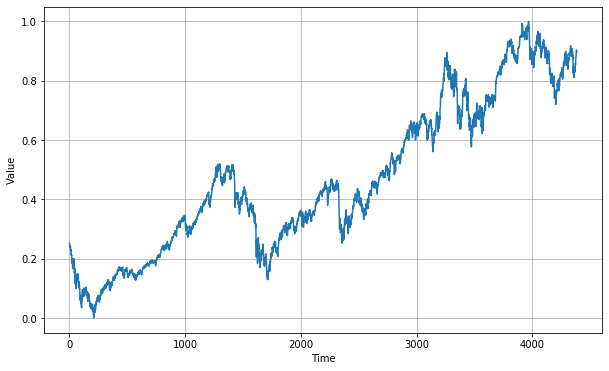

In [7]:
# plot DAX Adj Close over the time period
plt.figure(figsize=(10, 6))
plot_series(df_norm.index.values, df_norm["DAX_adj_close"].values)
plt.show()

**Create Evaluation Function**

As metric I will use: 
- Mean absolute error (MAE)
- R^2 
- Root mean square error (RMSE)

In [0]:
def get_evaluation(actual, prediction):
  mae = mean_absolute_error(actual, prediction) 
  r_2 = r2_score(actual,prediction)
  rmse = np.sqrt(mean_squared_error(actual,prediction))
  return mae, r_2, rmse

Normally I would split my dataset as mentioned in the propasal in three sets:
- Training 
- Validation and
- Test
set. 

But in the meantime I took Udacity's course: "Intro to TensorFlow for Deep Learning" (Lesson 8: Time Series Forecasting) and learned there that it's unusual to do this.
Because the test set is not reliable as in regular machine learning and because we need to use it for training before deploying on model, it is common to just use a training period and a validation period. In other words, the test period is in the future.
So I will do an 80% Training to 20% Validation set split. As I have at al 4384 points, that means: 
- Training 80% = 3,507
- Validation 20% = 876

In [0]:
split_time = 3507
time_train = df_norm.index.values[:split_time]
x_train = df_norm["DAX_adj_close"].values[:split_time]
time_valid = df_norm.index.values[split_time:]
x_valid = df_norm["DAX_adj_close"].values[split_time:]

## Develop and train models

### Linear Model / Linear Regression using sklearn

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
x_sklearn_train = time_train.reshape(-1,1)
y_sklearn_train = x_train.reshape(-1,1) 
x_sklearn_valid = time_valid.reshape(-1,1)
y_sklearn_valid = x_valid.reshape(-1,1)

In [0]:
regressor = LinearRegression()

In [0]:
regressor.fit(x_sklearn_train, y_sklearn_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
y_pred = regressor.predict(x_sklearn_valid)

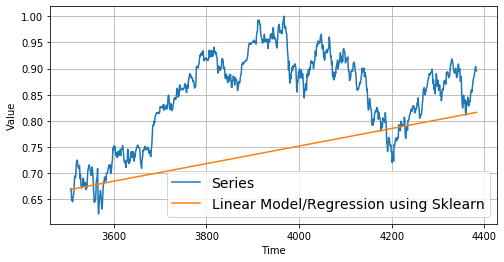

In [0]:
plt.figure(figsize=(8,4))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, y_pred, label="Linear Model/Regression using Sklearn")

In [0]:
MAE, R_2, RMSE = get_evaluation(x_valid, y_pred)
print("Model: Linear Regression(Sklearn)",
      "\nMAE:", MAE,
      "\nR_2:", R_2,
      "\nRMSE:", RMSE)

Model: Linear Regression(Sklearn) 
MAE: 0.10624727884119481 
R_2: -1.2640475644640832 
RMSE: 0.12750324747954495


### Linear Model / Linear Regression using Tensorflow 

#### Preparing

First I will train a model to forecast the next step given the previous 30 steps, therefore, I need to create dataset of 30-step windows for training.

In [0]:
# create window dataset
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

#### Build Linear Model / Linear Regression

First I train the model and check the mae on training and validation set.

In [0]:
# clear everythin to make sure we start back from zero
keras.backend.clear_session()
# set seed to a value to ensure that the code is repeatable, if running multiple times
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])                                
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
test = model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
109/109 [==============================] - 2s 15ms/step - loss: 0.3481 - mae: 0.7589 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
109/109 [==============================] - 1s 6ms/step - loss: 0.2717 - mae: 0.7149 - val_loss: 1.0876 - val_mae: 1.5879
Epoch 3/100
109/109 [==============================] - 1s 7ms/step - loss: 0.2424 - mae: 0.6721 - val_loss: 1.0003 - val_mae: 1.5008
Epoch 4/100
109/109 [==============================] - 1s 6ms/step - loss: 0.2158 - mae: 0.6309 - val_loss: 0.9178 - val_mae: 1.4171
Epoch 5/100
109/109 [==============================] - 1s 6ms/step - loss: 0.1920 - mae: 0.5913 - val_loss: 0.8368 - val_mae: 1.3367
Epoch 6/100
109/109 [==============================] - 1s 6ms/step - loss: 0.1692 - mae: 0.5531 - val_loss: 0.7599 - val_mae: 1.2596
Epoch 7/100
109/109 [==============================] - 1s 6ms/step - loss: 0.1491 - mae: 0.5168 - val_loss: 0.6856 - val_mae: 1.1864
Epoch 8/100
109/109 [==============================] - 1s 6m

Finding the right learning rate using lambda epoch function

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
109/109 [==============================] - 1s 10ms/step - loss: 0.2532 - mae: 0.6365
Epoch 2/100
109/109 [==============================] - 1s 6ms/step - loss: 0.2483 - mae: 0.6323
Epoch 3/100
109/109 [==============================] - 1s 5ms/step - loss: 0.2455 - mae: 0.6279
Epoch 4/100
109/109 [==============================] - 1s 5ms/step - loss: 0.2427 - mae: 0.6230
Epoch 5/100
109/109 [==============================] - 1s 6ms/step - loss: 0.2379 - mae: 0.6179
Epoch 6/100
109/109 [==============================] - 1s 5ms/step - loss: 0.2341 - mae: 0.6123
Epoch 7/100
109/109 [==============================] - 1s 5ms/step - loss: 0.2298 - mae: 0.6063
Epoch 8/100
109/109 [==============================] - 1s 6ms/step - loss: 0.2256 - mae: 0.5999
Epoch 9/100
109/109 [==============================] - 1s 5ms/step - loss: 0.2214 - mae: 0.5931
Epoch 10/100
109/109 [==============================] - 1s 5ms/step - loss: 0.2157 - mae: 0.5857
Epoch 11/100
109/109 [================

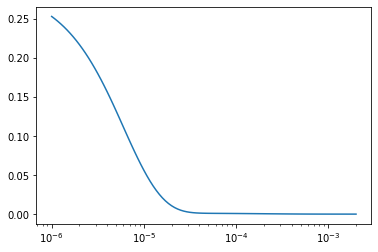

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])

Learning rate is getting better and better, so I will take 10e-3

I train the model and check the mae on training and validation set. I will do this for 500 epochs. IF the model doesn't improve for 10 epochs, it will terminate.

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=10e-3, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
109/109 [==============================] - 1s 12ms/step - loss: 0.0092 - mae: 0.0891 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
109/109 [==============================] - 1s 7ms/step - loss: 6.8853e-04 - mae: 0.0274 - val_loss: 6.0423e-04 - val_mae: 0.0273
Epoch 3/500
109/109 [==============================] - 1s 7ms/step - loss: 4.2916e-04 - mae: 0.0228 - val_loss: 5.9975e-04 - val_mae: 0.0274
Epoch 4/500
109/109 [==============================] - 1s 6ms/step - loss: 4.1130e-04 - mae: 0.0223 - val_loss: 6.2514e-04 - val_mae: 0.0281
Epoch 5/500
109/109 [==============================] - 1s 6ms/step - loss: 3.9980e-04 - mae: 0.0221 - val_loss: 5.8580e-04 - val_mae: 0.0272
Epoch 6/500
109/109 [==============================] - 1s 6ms/step - loss: 3.9427e-04 - mae: 0.0218 - val_loss: 5.9642e-04 - val_mae: 0.0272
Epoch 7/500
109/109 [==============================] - 1s 6ms/step - loss: 3.8354e-04 - mae: 0.0216 - val_loss: 5.5708e-04 - val_mae: 0.0262
Epoch 8/500


In [0]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [0]:
lin_forecast = model_forecast(model, df_norm["DAX_adj_close"].values[split_time - window_size:-1], window_size)[:, 0]

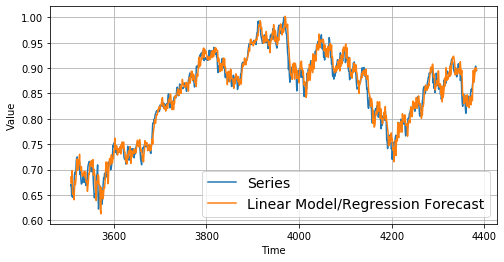

In [0]:
plt.figure(figsize=(8, 4))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, lin_forecast, label="Linear Model/Regression Forecast")

In [0]:
MAE, R_2, RMSE = get_evaluation(x_valid, lin_forecast)
print("Model: Lin Forecast",
      "\nMAE:", MAE,
      "\nR_2:", R_2,
      "\nRMSE:", RMSE)

Model: Lin Forecast 
MAE: 0.01242074316812058 
R_2: 0.9646051283521777 
RMSE: 0.015942214343151323


### LSTM

#### Preparing

For the LSTM I need a new data window. The last one was stateless and now I need a stateful one. That means, that it can't randomly take batches, instead it has to take them sequentially. So the LSTM can learn patterns longer than the batch size.

In [0]:
# create new window function
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

But as the LSTM don't know the end of a time series, I need to tell it. One way is to define a custom callback. Therefore I need to create a subclass of the "keras.callbacks.callback" class and also implement the "on_epoch_begin" method and make it call "self.model.reset_sates". So the LSTM states will be reset before each epoch.

In [0]:
class ResetStatesCallback(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

#### Run Basic LSTM

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model.fit(train_set, epochs=100,
          validation_data=valid_set,
          callbacks=[reset_states])

Epoch 1/100
116/116 [==============================] - 4s 34ms/step - loss: 0.7621 - mae: 1.1625 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
116/116 [==============================] - 1s 7ms/step - loss: 1.7662 - mae: 1.7853 - val_loss: 0.4145 - val_mae: 0.8067
Epoch 3/100
116/116 [==============================] - 1s 7ms/step - loss: 1.4048 - mae: 1.4487 - val_loss: 0.4790 - val_mae: 0.9018
Epoch 4/100
116/116 [==============================] - 1s 7ms/step - loss: 1.2258 - mae: 1.2986 - val_loss: 0.4859 - val_mae: 0.9111
Epoch 5/100
116/116 [==============================] - 1s 7ms/step - loss: 1.1794 - mae: 1.2538 - val_loss: 0.4765 - val_mae: 0.9010
Epoch 6/100
116/116 [==============================] - 1s 7ms/step - loss: 1.1355 - mae: 1.2117 - val_loss: 0.4643 - val_mae: 0.8877
Epoch 7/100
116/116 [==============================] - 1s 7ms/step - loss: 1.0912 - mae: 1.1706 - val_loss: 0.4496 - val_mae: 0.8714
Epoch 8/100
116/116 [==============================] - 1s 7m

In [0]:
lstm_forecast_basic = model.predict(df_norm["DAX_adj_close"][np.newaxis, :, np.newaxis])
lstm_forecast_basic = lstm_forecast_basic[0, split_time - 1:-1, 0]

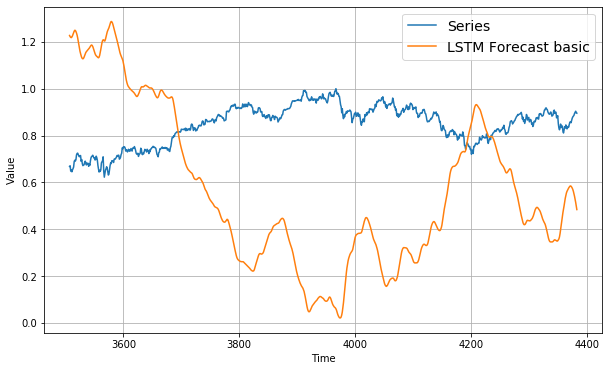

In [20]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, lstm_forecast_basic, label="LSTM Forecast basic")

In [21]:
MAE, R_2, RMSE = get_evaluation(x_valid, lstm_forecast_basic)
print("Model: LSTM Forecast Basic",
      "\nMAE:", MAE,
      "\nR_2:", R_2,
      "\nRMSE:", RMSE)

Model: LSTM Forecast Basic 
MAE: 0.4492951466800088 
R_2: -34.480777450507915 
RMSE: 0.5047484997386988


#### Tune Hyperparameters

1. Optimize Learning Rate

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=10e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
116/116 [==============================] - 5s 39ms/step - loss: 4.4805 - mae: 4.9782
Epoch 2/100
116/116 [==============================] - 1s 7ms/step - loss: 2.9540 - mae: 3.4551
Epoch 3/100
116/116 [==============================] - 1s 7ms/step - loss: 2.1111 - mae: 2.5967
Epoch 4/100
116/116 [==============================] - 1s 6ms/step - loss: 1.7565 - mae: 2.2411
Epoch 5/100
116/116 [==============================] - 1s 7ms/step - loss: 1.6602 - mae: 2.1165
Epoch 6/100
116/116 [==============================] - 1s 7ms/step - loss: 1.6455 - mae: 2.1007
Epoch 7/100
116/116 [==============================] - 1s 7ms/step - loss: 1.6324 - mae: 2.0866
Epoch 8/100
116/116 [==============================] - 1s 7ms/step - loss: 1.6022 - mae: 2.0540
Epoch 9/100
116/116 [==============================] - 1s 6ms/step - loss: 1.5600 - mae: 2.0087
Epoch 10/100
116/116 [==============================] - 1s 7ms/step - loss: 1.5100 - mae: 1.9552
Epoch 11/100
116/116 [================

[1e-07, 1e-05, 0, 5]

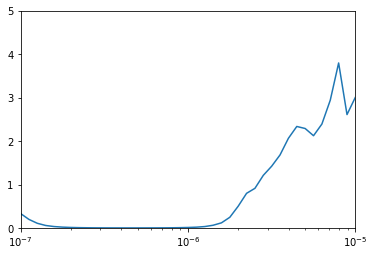

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([10e-8, 1e-5,0,5])

So I will take a learning rate of 5e-7

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model.fit(train_set, epochs=100,
          validation_data=valid_set,
          callbacks=[reset_states])

Epoch 1/100
116/116 [==============================] - 4s 36ms/step - loss: 0.7034 - mae: 1.0870 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
116/116 [==============================] - 1s 7ms/step - loss: 1.8670 - mae: 1.8378 - val_loss: 0.6496 - val_mae: 1.0893
Epoch 3/100
116/116 [==============================] - 1s 7ms/step - loss: 1.4792 - mae: 1.5430 - val_loss: 0.6242 - val_mae: 1.0544
Epoch 4/100
116/116 [==============================] - 1s 7ms/step - loss: 1.2014 - mae: 1.3338 - val_loss: 0.5611 - val_mae: 0.9797
Epoch 5/100
116/116 [==============================] - 1s 7ms/step - loss: 0.9817 - mae: 1.1569 - val_loss: 0.3727 - val_mae: 0.7788
Epoch 6/100
116/116 [==============================] - 1s 7ms/step - loss: 0.8252 - mae: 1.0016 - val_loss: 0.2133 - val_mae: 0.5815
Epoch 7/100
116/116 [==============================] - 1s 7ms/step - loss: 0.6597 - mae: 0.8444 - val_loss: 0.1208 - val_mae: 0.4326
Epoch 8/100
116/116 [==============================] - 1s 7m

In [0]:
lstm_forecast_improved = model.predict(df_norm["DAX_adj_close"][np.newaxis, :, np.newaxis])
lstm_forecast_improved = lstm_forecast_improved[0, split_time - 1:-1, 0]

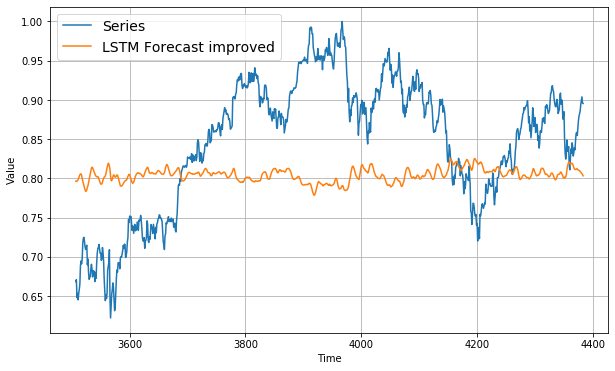

In [24]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, lstm_forecast_improved, label="LSTM Forecast improved")

In [25]:
MAE, R_2, RMSE = get_evaluation(x_valid, lstm_forecast_improved)
print("Model: LSTM Forecast improved",
      "\nMAE:", MAE,
      "\nR_2:", R_2,
      "\nRMSE:", RMSE)

Model: LSTM Forecast improved 
MAE: 0.08430913681134111 
R_2: -0.30569775754412776 
RMSE: 0.09682774151463726


**Optimized Learning rate of 5e-7 and more epochs**

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
116/116 [==============================] - 6s 50ms/step - loss: 0.7034 - mae: 1.0870 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
116/116 [==============================] - 1s 7ms/step - loss: 1.8670 - mae: 1.8378 - val_loss: 0.6496 - val_mae: 1.0893
Epoch 3/500
116/116 [==============================] - 1s 7ms/step - loss: 1.4792 - mae: 1.5430 - val_loss: 0.6242 - val_mae: 1.0544
Epoch 4/500
116/116 [==============================] - 1s 7ms/step - loss: 1.2014 - mae: 1.3338 - val_loss: 0.5611 - val_mae: 0.9797
Epoch 5/500
116/116 [==============================] - 1s 7ms/step - loss: 0.9817 - mae: 1.1569 - val_loss: 0.3727 - val_mae: 0.7788
Epoch 6/500
116/116 [==============================] - 1s 7ms/step - loss: 0.8252 - mae: 1.0016 - val_loss: 0.2133 - val_mae: 0.5815
Epoch 7/500
116/116 [==============================] - 1s 7ms/step - loss: 0.6597 - mae: 0.8444 - val_loss: 0.1208 - val_mae: 0.4326
Epoch 8/500
116/116 [==============================] - 1s 7m

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
lstm_forecast_improved = model.predict(df_norm["DAX_adj_close"][np.newaxis, :, np.newaxis])
lstm_forecast_improved = lstm_forecast_improved[0, split_time - 1:-1, 0]

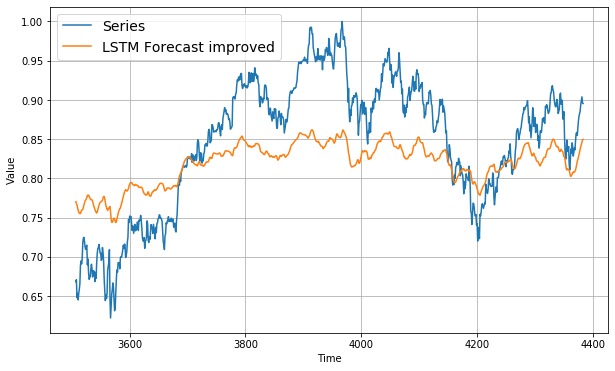

In [0]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, lstm_forecast_improved, label="LSTM Forecast improved")

In [0]:
MAE, R_2, RMSE = get_evaluation(x_valid, lstm_forecast_improved)
print("Model: LSTM Forecast Basic",
      "\nMAE:", MAE,
      "\nR_2:", R_2,
      "\nRMSE:", RMSE)

Model: LSTM Forecast Basic 
MAE: 0.05638045218114671 
R_2: 0.4174781786364249 
RMSE: 0.06467472226754957


Change window size to 15

In [29]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 15
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
233/233 [==============================] - 5s 20ms/step - loss: 0.4452 - mae: 0.8236 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
233/233 [==============================] - 1s 6ms/step - loss: 0.9845 - mae: 1.1251 - val_loss: 0.8069 - val_mae: 1.2468
Epoch 3/500
233/233 [==============================] - 2s 6ms/step - loss: 0.8385 - mae: 1.0092 - val_loss: 0.7940 - val_mae: 1.2244
Epoch 4/500
233/233 [==============================] - 2s 6ms/step - loss: 0.7314 - mae: 0.9236 - val_loss: 0.8168 - val_mae: 1.2454
Epoch 5/500
233/233 [==============================] - 1s 6ms/step - loss: 0.6527 - mae: 0.8608 - val_loss: 0.8403 - val_mae: 1.2735
Epoch 6/500
233/233 [==============================] - 1s 6ms/step - loss: 0.5946 - mae: 0.8153 - val_loss: 0.8565 - val_mae: 1.2912
Epoch 7/500
233/233 [==============================] - 1s 6ms/step - loss: 0.5524 - mae: 0.7823 - val_loss: 0.8668 - val_mae: 1.3019
Epoch 8/500
233/233 [==============================] - 2s 7m

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
lstm_forecast_improved = model.predict(df_norm["DAX_adj_close"][np.newaxis, :, np.newaxis])
lstm_forecast_improved = lstm_forecast_improved[0, split_time - 1:-1, 0]

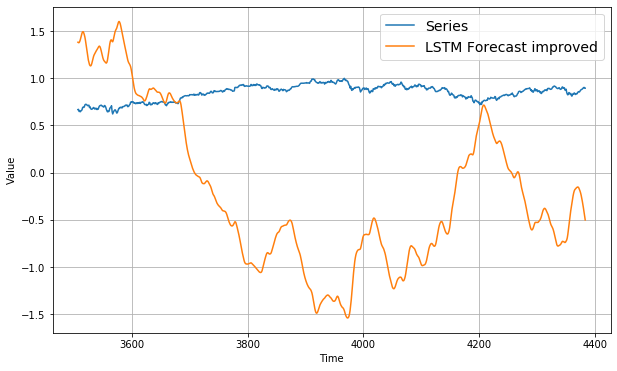

In [32]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, lstm_forecast_improved, label="LSTM Forecast improved")

In [33]:
MAE, R_2, RMSE = get_evaluation(x_valid, lstm_forecast_improved)
print("Model: LSTM Forecast Improved",
      "\nMAE:", MAE,
      "\nR_2:", R_2,
      "\nRMSE:", RMSE)

Model: LSTM Forecast Basic 
MAE: 1.2211615022358673 
R_2: -271.6258190152254 
RMSE: 1.3991425511016982


Higher Batch Size

In [34]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 60
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
58/58 [==============================] - 3s 56ms/step - loss: 1.0658 - mae: 1.4910 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
58/58 [==============================] - 1s 9ms/step - loss: 3.6345 - mae: 2.8472 - val_loss: 0.3229 - val_mae: 0.6763
Epoch 3/500
58/58 [==============================] - 1s 9ms/step - loss: 2.4243 - mae: 1.9927 - val_loss: 0.2270 - val_mae: 0.5146
Epoch 4/500
58/58 [==============================] - 1s 9ms/step - loss: 1.5745 - mae: 1.4812 - val_loss: 0.0952 - val_mae: 0.3437
Epoch 5/500
58/58 [==============================] - 1s 9ms/step - loss: 0.8299 - mae: 1.0512 - val_loss: 0.0526 - val_mae: 0.2832
Epoch 6/500
58/58 [==============================] - 1s 9ms/step - loss: 0.4189 - mae: 0.6533 - val_loss: 0.0556 - val_mae: 0.2949
Epoch 7/500
58/58 [==============================] - 1s 9ms/step - loss: 0.2899 - mae: 0.5243 - val_loss: 0.0377 - val_mae: 0.2421
Epoch 8/500
58/58 [==============================] - 1s 9ms/step - loss: 0

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
lstm_forecast_improved = model.predict(df_norm["DAX_adj_close"][np.newaxis, :, np.newaxis])
lstm_forecast_improved = lstm_forecast_improved[0, split_time - 1:-1, 0]

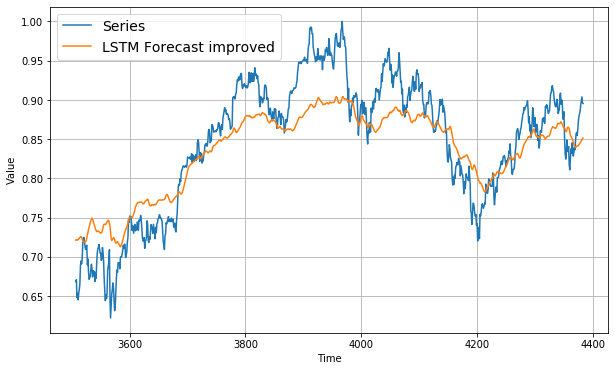

In [37]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, lstm_forecast_improved, label="LSTM Forecast improved")

In [38]:
MAE, R_2, RMSE = get_evaluation(x_valid, lstm_forecast_improved)
print("Model: LSTM Forecast Improved",
      "\nMAE:", MAE,
      "\nR_2:", R_2,
      "\nRMSE:", RMSE)

Model: LSTM Forecast Improved 
MAE: 0.03310048158980522 
R_2: 0.7754892075684258 
RMSE: 0.04015106639205273


Again double batch size = 120

In [39]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 120
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
29/29 [==============================] - 4s 132ms/step - loss: 1.4429 - mae: 1.9083 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
29/29 [==============================] - 0s 12ms/step - loss: 3.5502 - mae: 3.4402 - val_loss: 4.8076 - val_mae: 5.3076
Epoch 3/500
29/29 [==============================] - 0s 13ms/step - loss: 1.9408 - mae: 2.0011 - val_loss: 1.9497 - val_mae: 2.4468
Epoch 4/500
29/29 [==============================] - 0s 12ms/step - loss: 2.8112 - mae: 2.8460 - val_loss: 2.7352 - val_mae: 3.2352
Epoch 5/500
29/29 [==============================] - 0s 13ms/step - loss: 1.2613 - mae: 1.3710 - val_loss: 0.2058 - val_mae: 0.5698
Epoch 6/500
29/29 [==============================] - 0s 12ms/step - loss: 2.0530 - mae: 2.1503 - val_loss: 0.4570 - val_mae: 0.8909
Epoch 7/500
29/29 [==============================] - 0s 12ms/step - loss: 1.0174 - mae: 1.1513 - val_loss: 0.0905 - val_mae: 0.3517
Epoch 8/500
29/29 [==============================] - 0s 13ms/step -

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
lstm_forecast_improved = model.predict(df_norm["DAX_adj_close"][np.newaxis, :, np.newaxis])
lstm_forecast_improved = lstm_forecast_improved[0, split_time - 1:-1, 0]

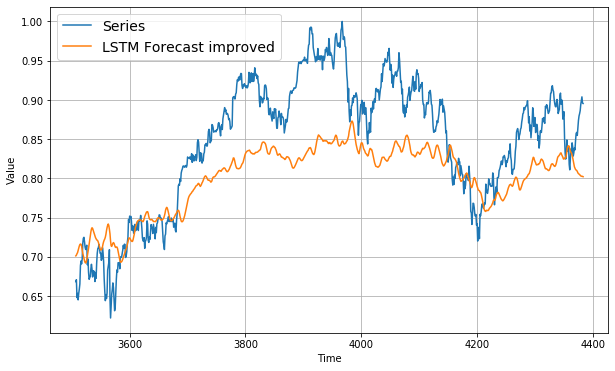

In [42]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, lstm_forecast_improved, label="LSTM Forecast improved")

In [43]:
MAE, R_2, RMSE = get_evaluation(x_valid, lstm_forecast_improved)
print("Model: LSTM Forecast Improved",
      "\nMAE:", MAE,
      "\nR_2:", R_2,
      "\nRMSE:", RMSE)

Model: LSTM Forecast Improved 
MAE: 0.0564194254292696 
R_2: 0.36822203892739414 
RMSE: 0.06735358380736665


Worse than the batch size of 60.

So I will do another run with batch size = 90

In [45]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 90
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
38/38 [==============================] - 4s 116ms/step - loss: 1.6802 - mae: 2.1610 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
38/38 [==============================] - 0s 11ms/step - loss: 2.1695 - mae: 2.0320 - val_loss: 0.7766 - val_mae: 1.2045
Epoch 3/500
38/38 [==============================] - 0s 10ms/step - loss: 3.9160 - mae: 3.6377 - val_loss: 1.7025 - val_mae: 2.1981
Epoch 4/500
38/38 [==============================] - 0s 11ms/step - loss: 2.2101 - mae: 2.0320 - val_loss: 0.2042 - val_mae: 0.4965
Epoch 5/500
38/38 [==============================] - 0s 11ms/step - loss: 1.9953 - mae: 1.7205 - val_loss: 0.1202 - val_mae: 0.4318
Epoch 6/500
38/38 [==============================] - 0s 11ms/step - loss: 1.1836 - mae: 1.1388 - val_loss: 0.1494 - val_mae: 0.4684
Epoch 7/500
38/38 [==============================] - 0s 11ms/step - loss: 0.6593 - mae: 0.7945 - val_loss: 0.0640 - val_mae: 0.3067
Epoch 8/500
38/38 [==============================] - 0s 11ms/step -

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
lstm_forecast_improved = model.predict(df_norm["DAX_adj_close"][np.newaxis, :, np.newaxis])
lstm_forecast_improved = lstm_forecast_improved[0, split_time - 1:-1, 0]

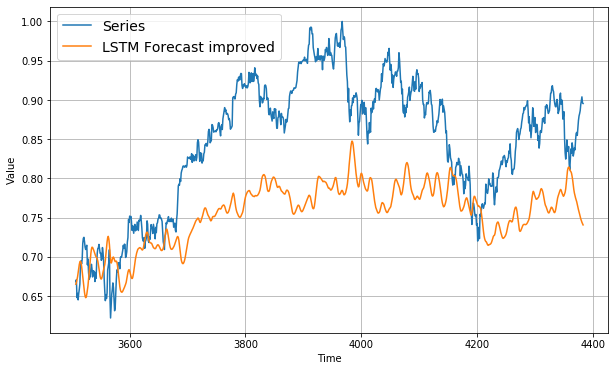

In [48]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, lstm_forecast_improved, label="LSTM Forecast improved")

In [49]:
MAE, R_2, RMSE = get_evaluation(x_valid, lstm_forecast_improved)
print("Model: LSTM Forecast Improved",
      "\nMAE:", MAE,
      "\nR_2:", R_2,
      "\nRMSE:", RMSE)

Model: LSTM Forecast Improved 
MAE: 0.09352447219110092 
R_2: -0.6220876704309071 
RMSE: 0.10792340393135318


Worse than batch size 60